<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [96]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [97]:
data['class'].unique()

array(['g', 'h'], dtype=object)

In [98]:
names[:-1]

array(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long',
       'M3Trans', 'Alpha', 'Dist'], dtype='<U7')

# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [99]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [100]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [101]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [102]:
# все возможные значения
np.unique(y)
# g - 1, h - 0

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [103]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

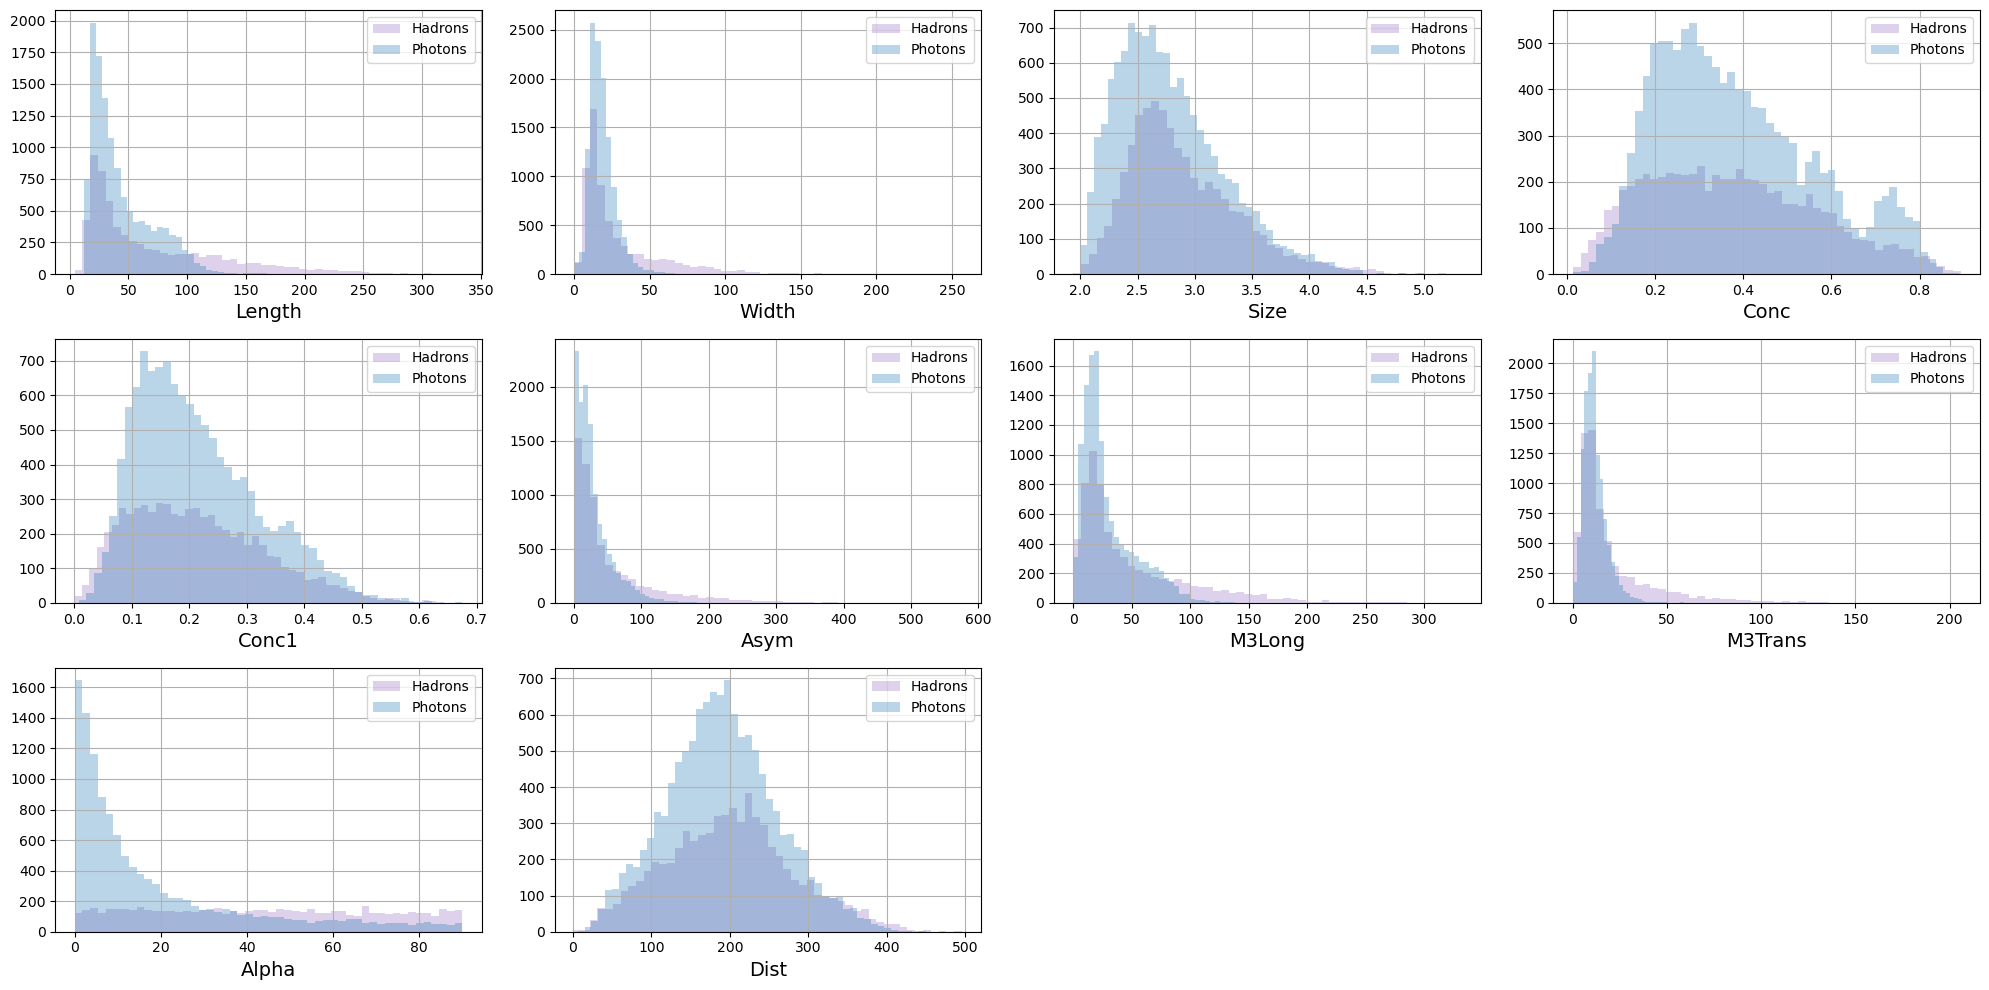

In [104]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

Для начала зафисксируем seed

In [105]:
import random
import os
import torch
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [106]:
seed_everything(13)

# Обучающая и тестовая выборки

In [107]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

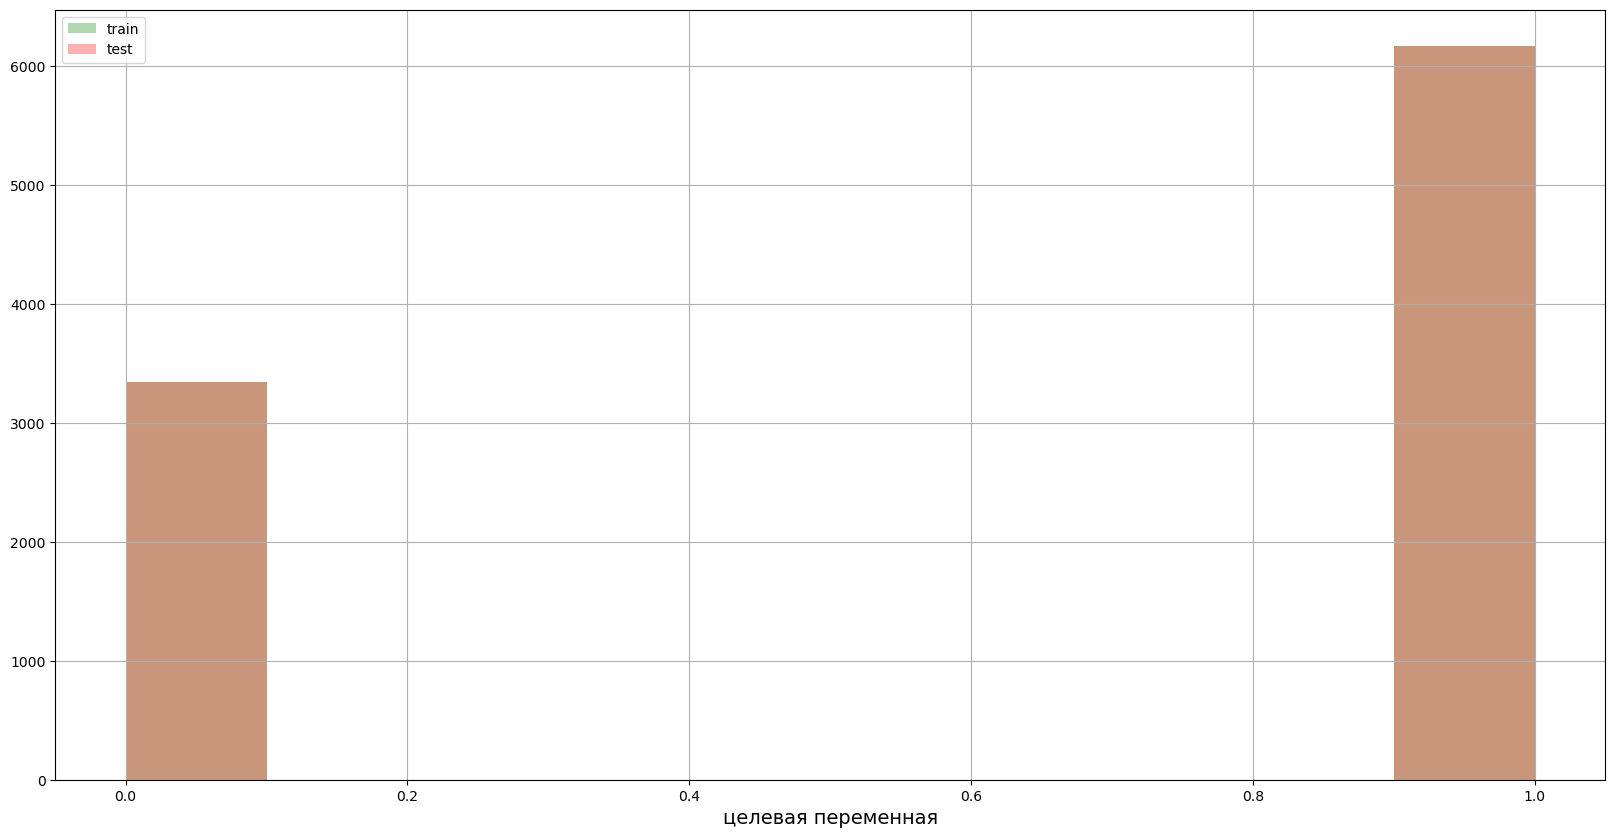

In [108]:
plt.figure(figsize=(5 * 4, 5 * 2))
plt.grid()
plt.hist(y_train, alpha=0.3, label='train', color="green")
plt.hist(y_test, alpha=0.3, label='test', color="red")
plt.xlabel('целевая переменная', size=14)
plt.legend(loc="best")

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [109]:
### YOUR CODE IS HERE ######
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution='normal')
qt.fit(X_train)
X_train = qt.transform(X_train)
X_test = qt.transform(X_test)
### THE END OF YOUR CODE ###

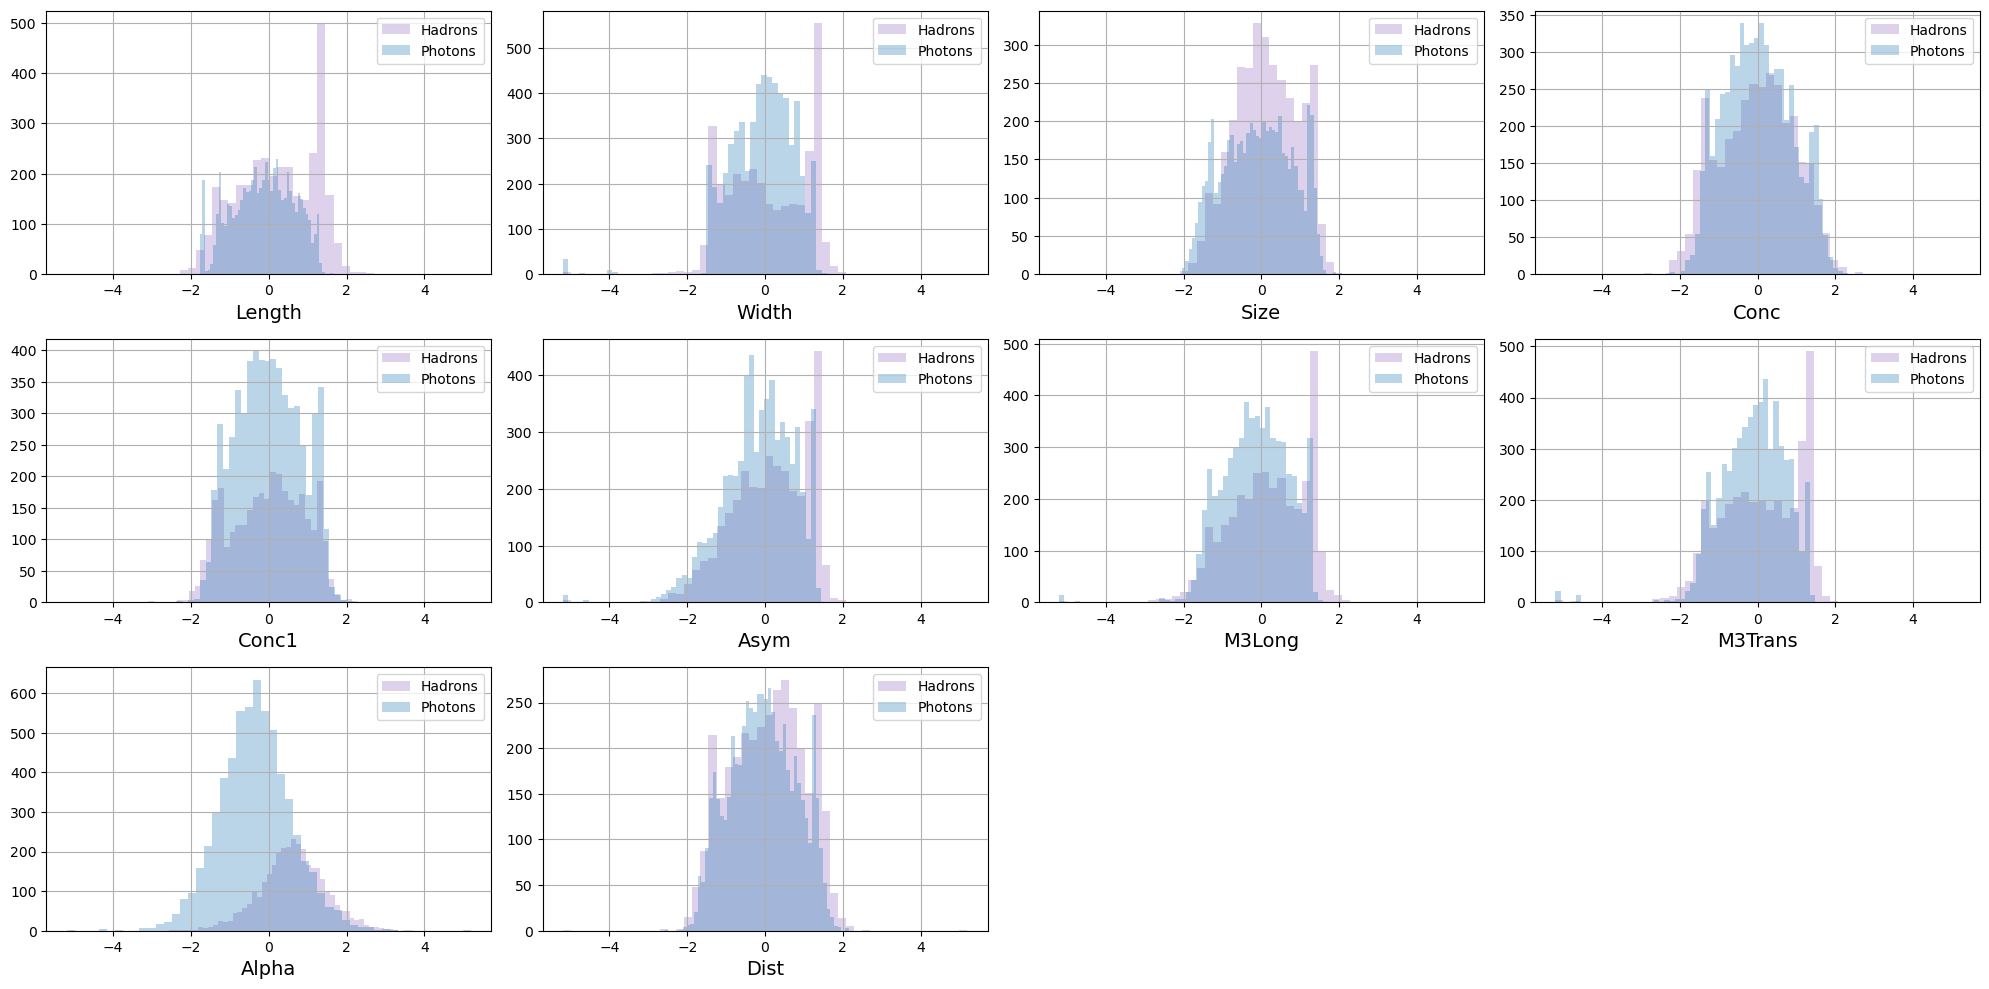

In [110]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

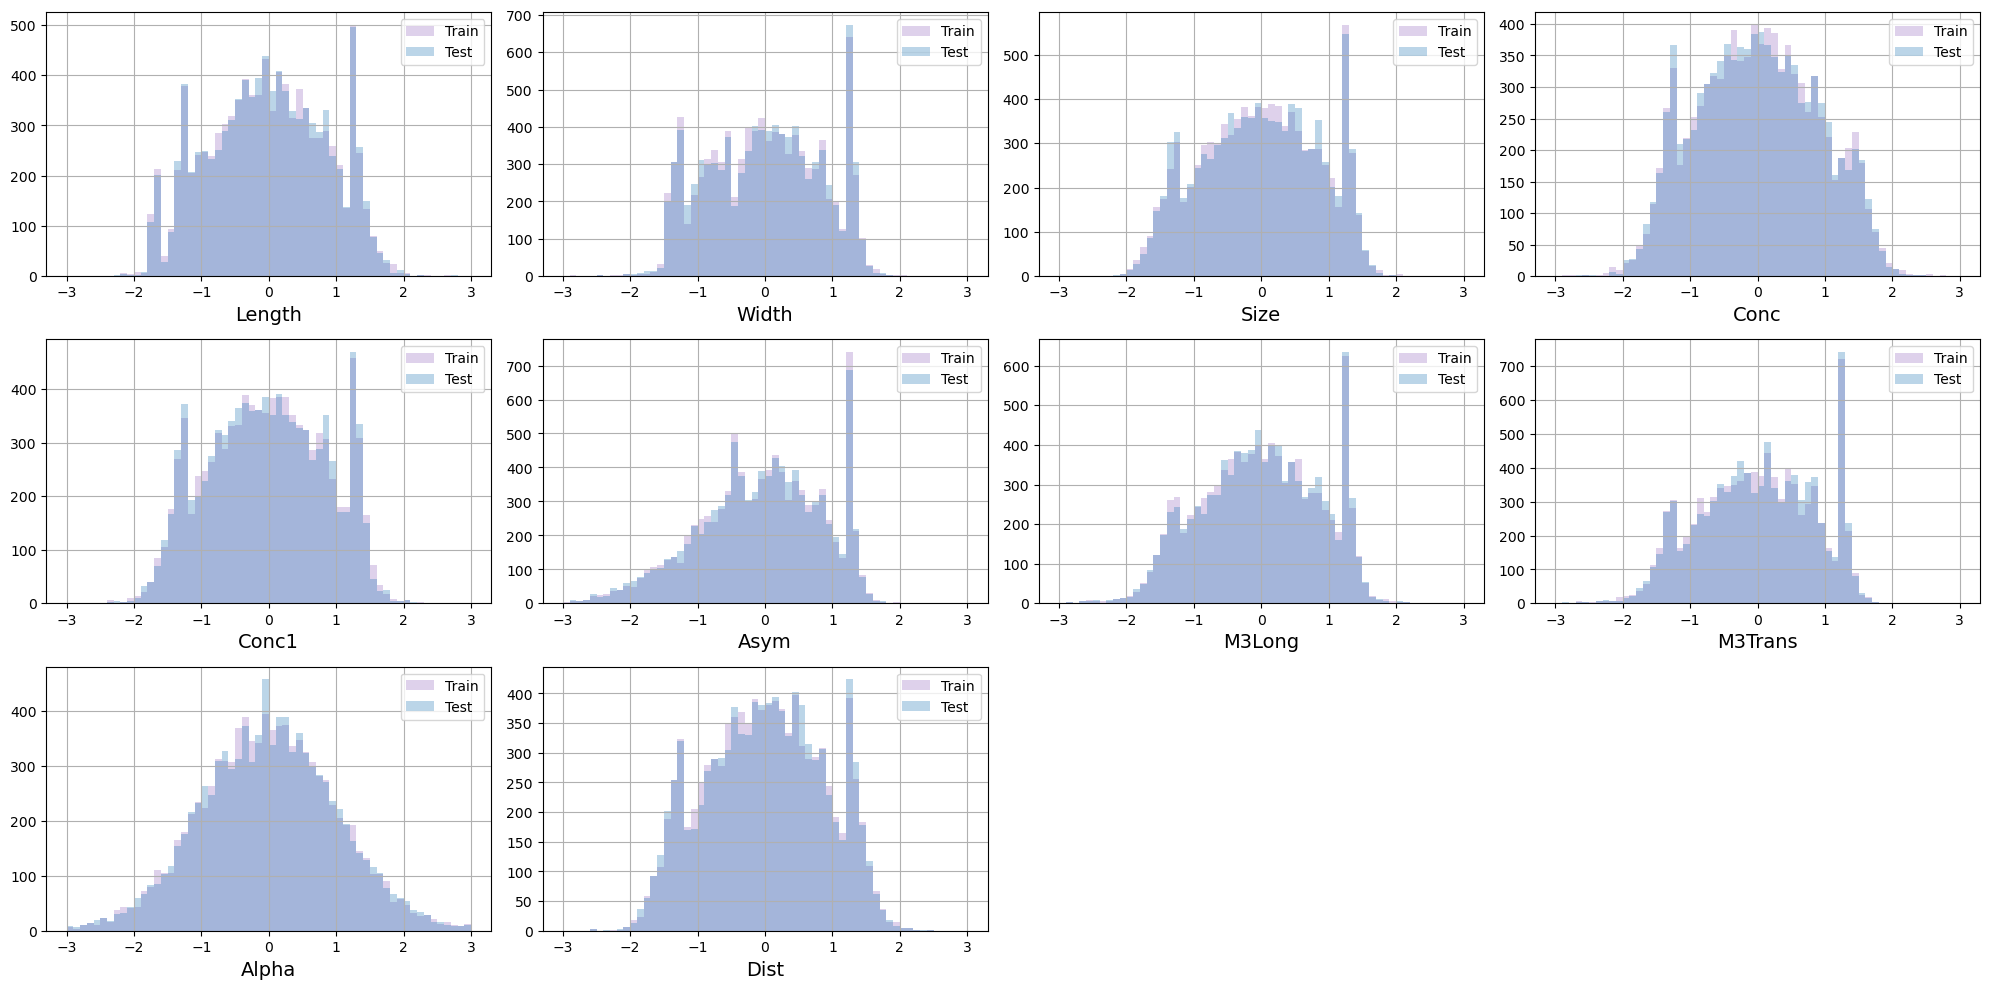

In [111]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [20]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, n_outputs),
        )

        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1) # склеили признаки и условие
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

В generate мы создаём шум размерности latent_dim, который юзается Generator'ом для создания новых данных

Т.е. по сути generate это
1) Создать шум размерности latent_dim

2) Юзнуть генератор для создания новых данных при помощи "y" и полученного шума

3) Вернуть новые данные

In [21]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    
    prior = torch.distributions.Normal(
        torch.zeros(latent_dim), torch.ones(latent_dim)
    ) # среднее значение 0, стандартное отклонение 1
    
    num_objects = y.shape[0]
    z = prior.sample((num_objects,))
    X_fake = generator(z, y)
    
    ### THE END OF YOUR CODE ###
    return X_fake.cpu().detach().numpy()  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [42]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid() # предсказывает вероятность принадлежность к классу
        )


        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    
    # модель должна отличать real и fake, соответсвенно это должно стать таргетом, а протон/нейтрон признаком
    full_X_real = torch.cat((X_real, y_real), dim=1)
    full_y_real = torch.ones(y_real.size(dim=0))
    full_X_fake = torch.cat((X_fake, y_fake), dim=1)
    full_y_fake = torch.zeros(y_real.size(dim=0))
    X = torch.cat((full_X_real, full_X_fake), dim=0).detach().numpy()
    y = torch.cat((full_y_real, full_y_fake), dim=0).detach().numpy()
    strat = np.zeros(y.shape[0]) 
    strat[:(y.shape[0] // 4) * 3] += 1 #тут риал и фейк в соотношении 3 к 1
    print(X.shape, y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=strat)
    
    reg = LogisticRegression()
    print(y_train)
    reg.fit(X_train, y_train) # обучаем модель 
    predic_test_reg = reg.predict(X_test)
    
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    predic_test_clf = clf.predict(X_test)
    
    lin_reg_score = accuracy_score(y_test, predic_test_reg)
    boosting_score = accuracy_score(y_test, predic_test_clf)
    
    ### THE END OF YOUR CODE ###
#     print('Linear regression score: ' + str(lin_reg_score))
#     print('Boosting score: ' + str(boosting_score))
    
    return lin_reg_score, boosting_score

Мы хотим, чтобы фальшивые объекты были неотличимы от настоящих, тогда accuray должно быть около 0,5

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [44]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        self.gen_loss_history = []
        self.discr_loss_history = []
        self.boost_loss_history = []
        self.reg_loss_history = []
        
        st = 0
        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                
                z = torch.normal(0, 1, (real_batch.shape[0], self.latent_dim))
                fake_batch = self.generator(z, cond_batch)
                
                
                if (i % self.n_critic == 0):
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = torch.mean(self.discriminator(fake_batch, cond_batch))
                    gen_loss.backward()
                    self.opt_gen.step()
                    self.gen_loss_history.append((st, gen_loss.item()))  
                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()
                    discr_loss = torch.mean(self.discriminator(real_batch, cond_batch)) - torch.mean(self.discriminator(fake_batch, cond_batch))
                    discr_loss.backward()
                    self.opt_disc.step()
                    self.discr_loss_history.append((st, discr_loss.item()))  
                
                st += 1

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            xr = X_real[0:1000]
            yr = y_cond[0:1000]
            xf = X_fake[0:1000]
            yf = y_cond[0:1000]

            lin_reg_score, boosting_score = other_agent_score(xr, yr, xf, yf)
            self.reg_loss_history.append((epoch, lin_reg_score))
            self.boost_loss_history.append((epoch, boosting_score))
            # нарисуем графики с метриками, чтобы понять, что происходит
            clear_output(wait=True)
            plt.figure(figsize=(12, 6))

            plt.subplot(2, 2, 1)
            plt.xlabel("Iteration")
            plt.ylabel("Generator loss")
            plt.plot([p[0] for p in self.gen_loss_history], [p[1] for p in self.gen_loss_history])

            plt.subplot(2, 2, 2)
            plt.xlabel("Iteration")
            plt.ylabel("Discriminator loss")
            plt.plot(
                [p[0] for p in  self.discr_loss_history],
                [p[1] for p in  self.discr_loss_history],
                color="orange")
            
            plt.subplot(2, 2, 3)
            plt.xlabel("Epoch")
            plt.ylabel("Regression loss")
            plt.plot(
                [p[0] for p in self.reg_loss_history],
                [p[1] for p in self.reg_loss_history],
                color="purple")
            
            plt.subplot(2, 2, 4)
            plt.xlabel("Epoch")
            plt.ylabel("Boosting loss")
            plt.plot(
                [p[0] for p in self.boost_loss_history],
                [p[1] for p in self.boost_loss_history],
                color="green")
            
            plt.subplots_adjust(wspace=0.2)
            plt.show()                      
            ### THE END OF YOUR CODE ###
        
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

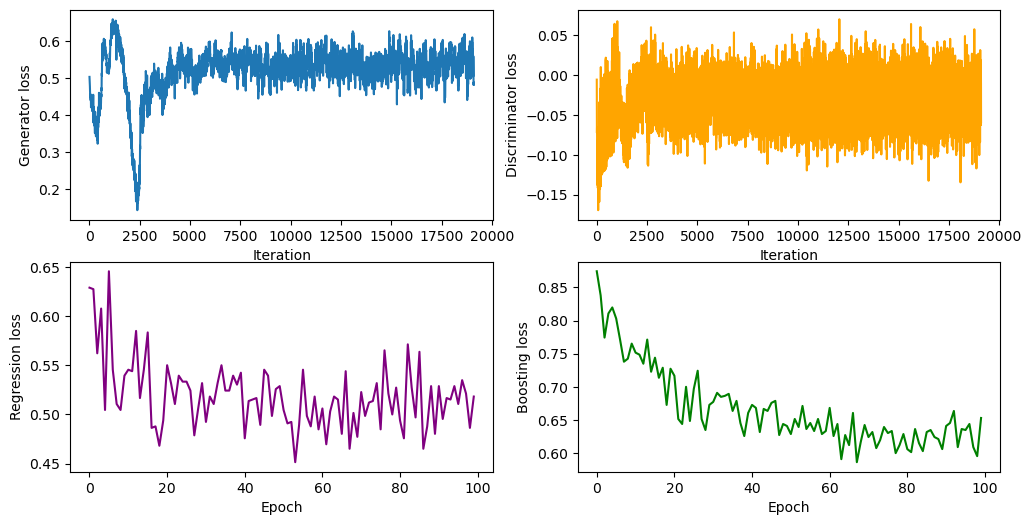

Wall time: 5min 1s


In [45]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

C:\Users\vbagrova\AppData\Local\Temp\ipykernel_17920\1676909197.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


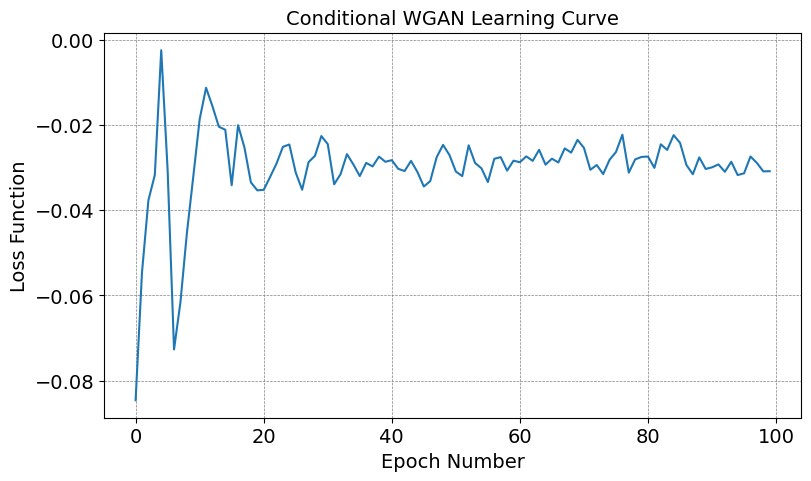

In [46]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [47]:
### YOUR CODE IS HERE ######
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)
### THE END OF YOUR CODE ###

In [48]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)

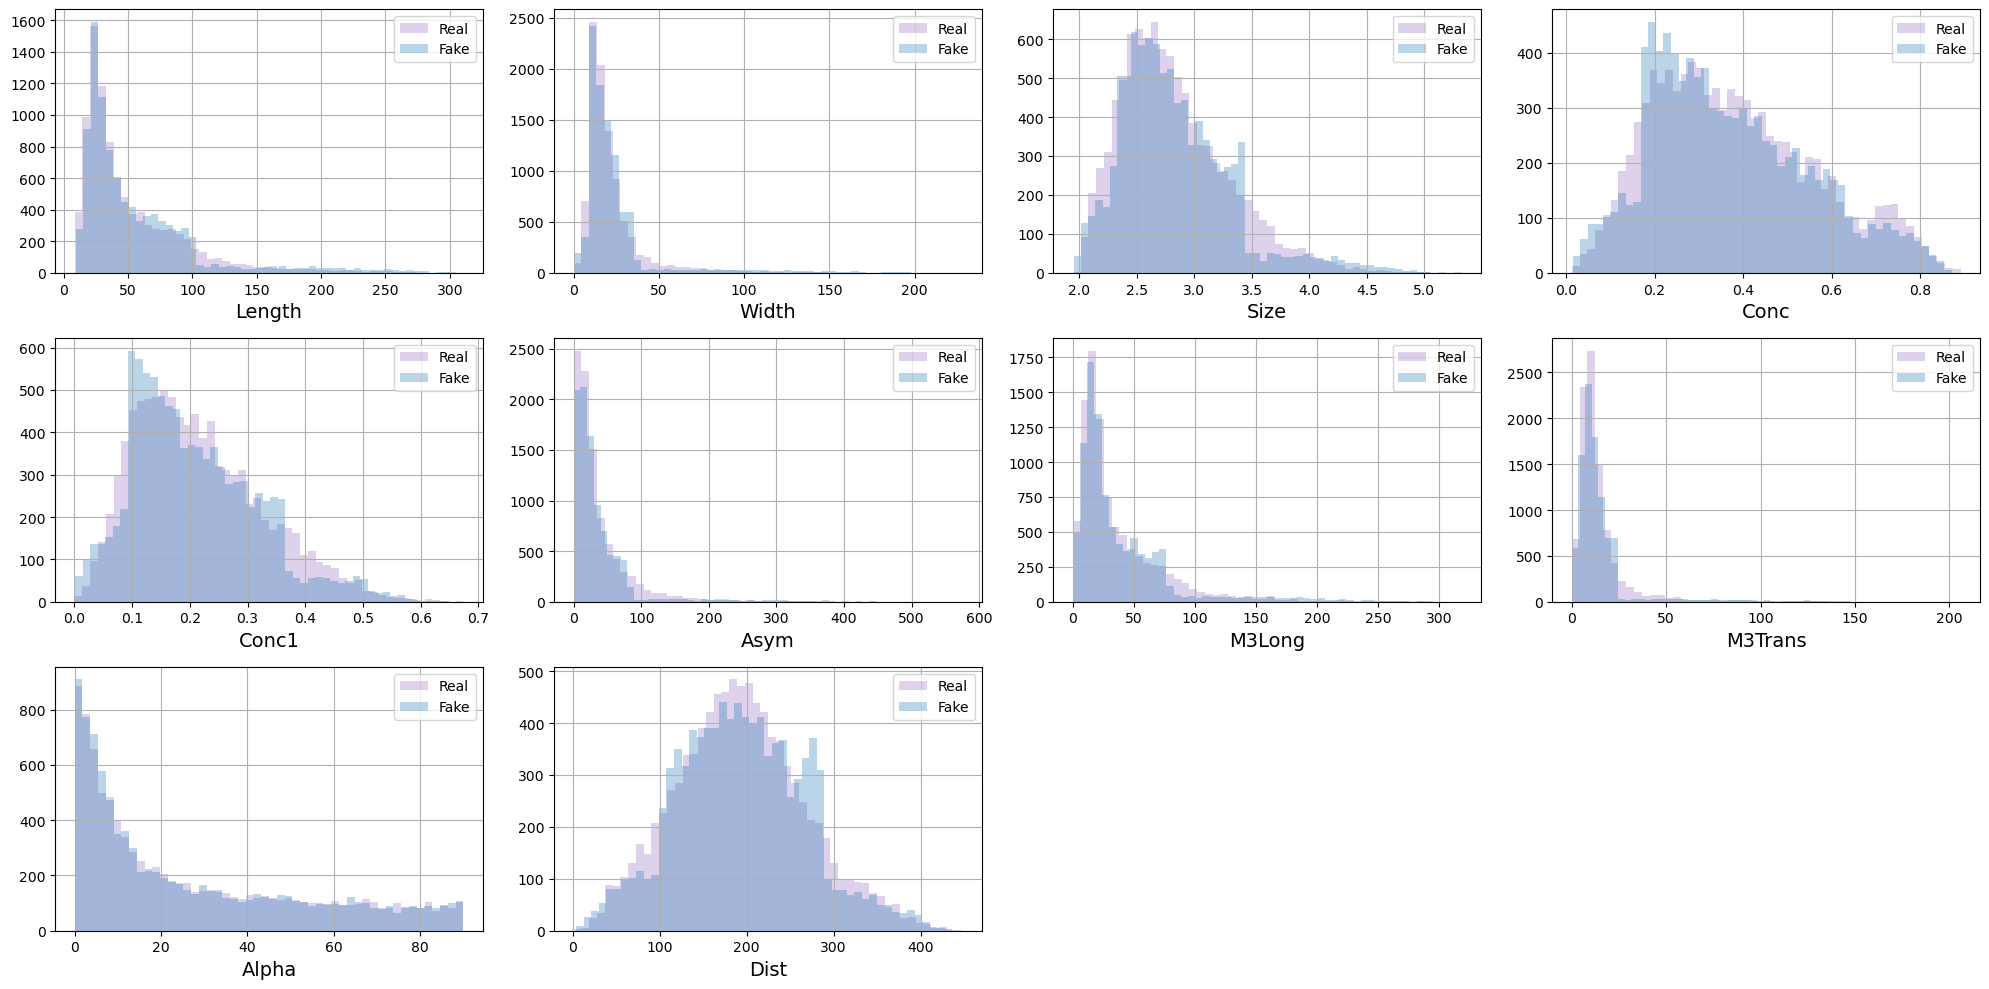

In [49]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [50]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)

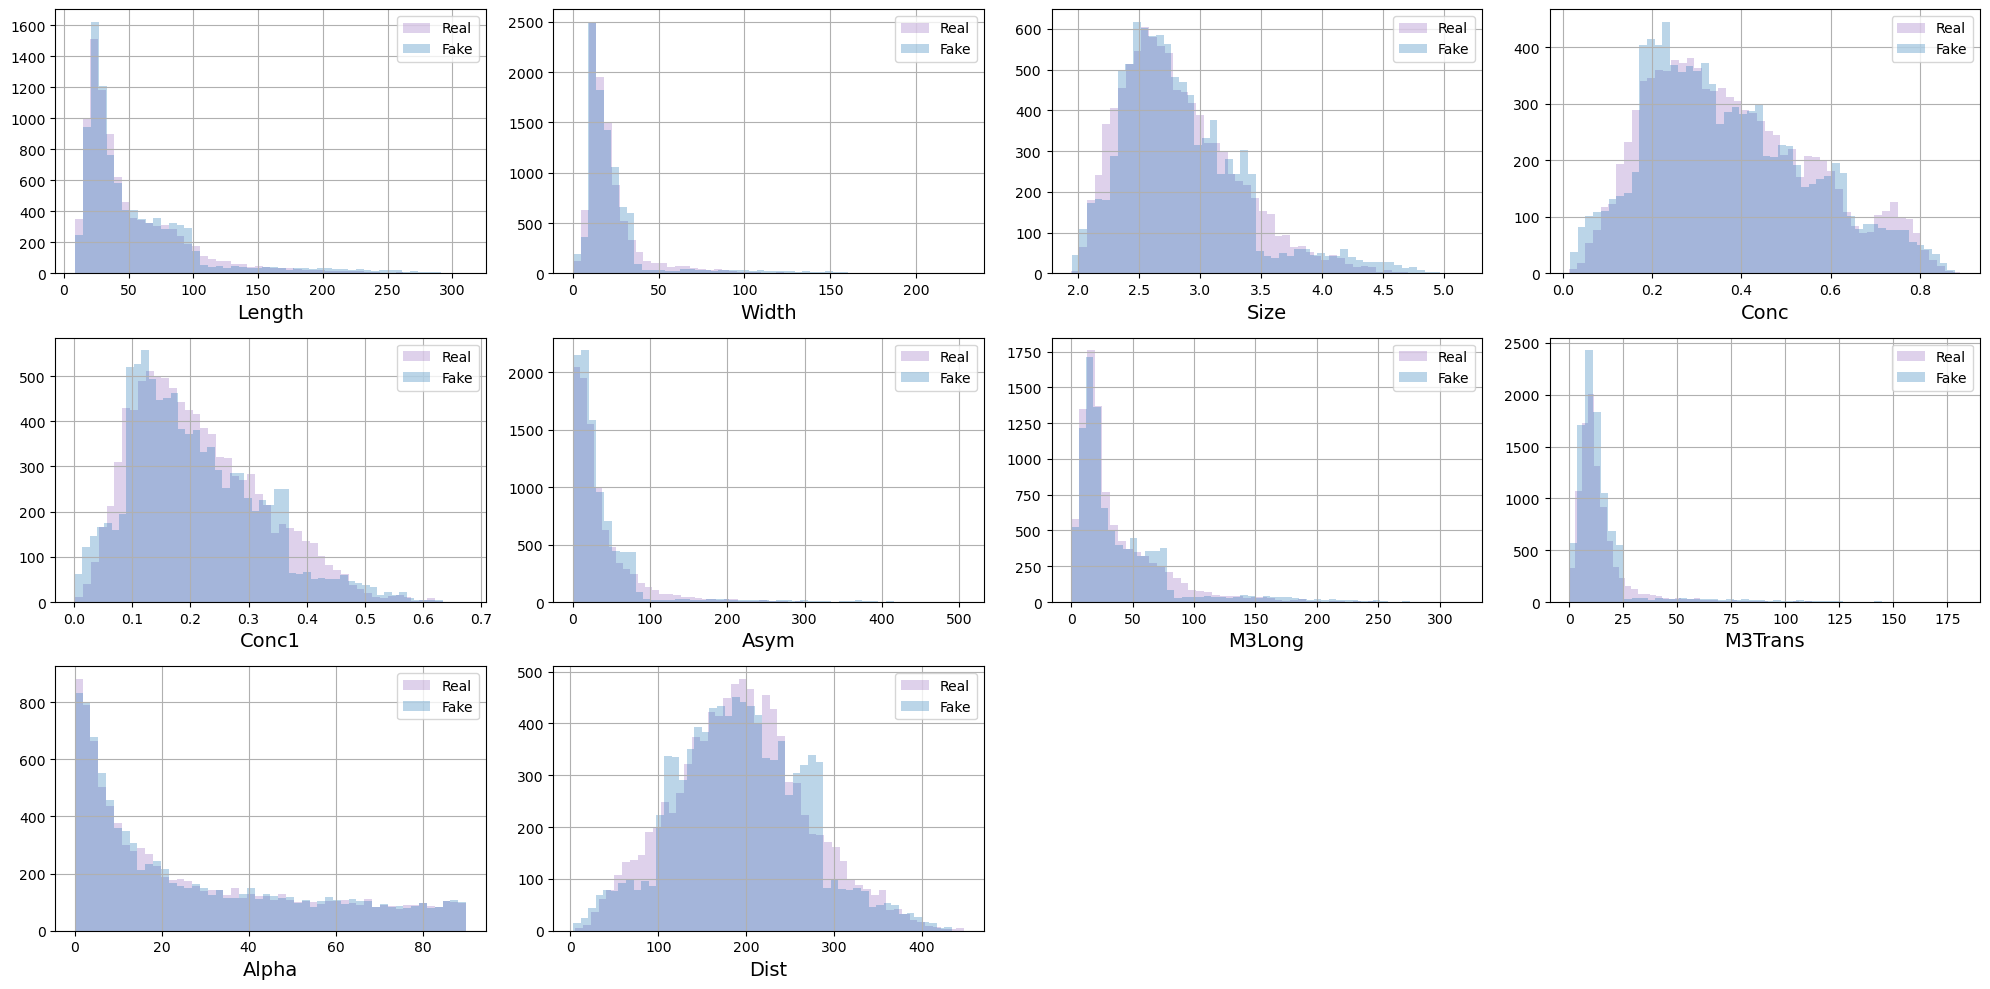

In [51]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [52]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [54]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7671103415409757


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


То, что модель вообще работает, это большой успех. Сначала auc roc был 0,81, увеличила кол-во выходных параметров в одном из слоев и стало получше. Даже с учетом того, что к этому моменту я разобралась как добавить stratify и классификаторы должны были обучаться чуть лучше, accuracy осталось приемлемым.
На отдельных признаках данные вообще замечательно предсказываются, распределения совпадают и хочется сказать, что я молодец. Но, к сожалению, общее распределении учитывает в себе комбинацию параметров и поэтому отдельные графички не показательны. Именно поэтому смотрим на auc_roc, который показывает, насколько хорошо мы умеем разделять классы. В целом, 0,76 это неплохой показатель, хотя идеалом было бы 0,5 (это бы означало, что модель вообще не умеет различать классы и делает это рандомно)

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

In [55]:
# !pip install -q diffusers
# !pip install DDPMScheduler
from diffusers import DDPMScheduler,UNet2DModel

In [56]:
# вернем наши данные в нормальное распределение
X_train = qt.transform(X_train)
X_test = qt.transform(X_test)

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [112]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.randn_like(x)# рандомный тензор такого же размера как x из нормального распределения
    amount = amount.view(-1, 1) # сколько шума мы хотим добавить
    x = x*(1-amount) + noise*amount
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

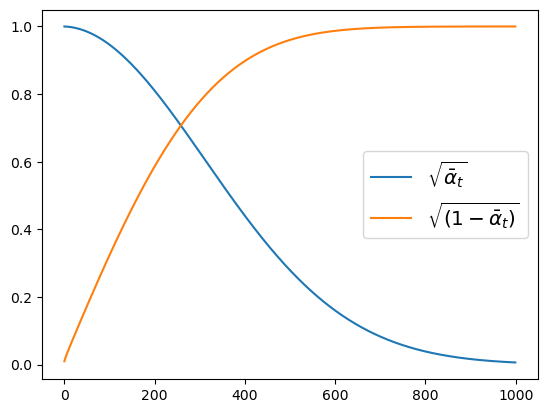

In [113]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [114]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    # передаем еще и номер шага
    def forward(self, z, t,  y):
        zy = torch.cat((z, y), dim=1)
        # мы хотим в предсказании учитывать timestamp. 
        # Не очень поняла, как передать в модель 2 переменные и кажется на этом этапе надо было отказаться от шедуллера 
        # и написать недодиффузионку, но я решила попробовать кое-что хитрожопое и поэтому сделала t еще одним признаком
        zyt = torch.cat((zy, t.unsqueeze(1)), dim=1) 
        return self.net(zyt)

По сути, наша модель будет предсказывать шум, который мы применили на определенном шаге. А мы как бы знаем, как мы данные зашумляли, соответсвено будем обычным mse сравнивать реальный и фейковый шумы

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [115]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    x = torch.normal(0, 1, (y.shape[0], latent_dim)) # генерим шум
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    
    for i, t in tqdm(enumerate(sheduler.timesteps)): # постепенно расшумляем
        
        with torch.no_grad():
            
            tt = torch.full((y.shape[0],), t)
            residual = model(x, tt, y)  
            
        x = noise_scheduler.step(residual, t, x).prev_sample
    
    X_fake = x
    ### THE END OF YOUR CODE ###
    return X_fake
# .cpu().detach().numpy() # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [116]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        scheduler,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.mse = nn.MSELoss()
        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        self.reg_loss_history = []
        self.boost_loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                noise = torch.randn_like(real_batch) # создали шум из нормального распределения совпадающий с размером батча
                timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long().to(DEVICE) # сгенерировали кол-во итераций
                noisy_x = self.scheduler.add_noise(real_batch, noise, timesteps) 
                pred = self.model(noisy_x, timesteps, cond_batch)
                
                loss = self.mse(pred, noisy_x)
                
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()
                
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch)
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            
            ### YOUR CODE IS HERE ######
            X_fake = generate_with_diffusion(self.model, y_cond, self.latent_dim, self.scheduler)
            
            xr = X_real[0:1000]
            yr = y_cond[0:1000]
            xf = X_fake[0:1000]
            yf = y_cond[0:1000]

            lin_reg_score, boosting_score = other_agent_score(xr, yr, xf, yf)
            self.reg_loss_history.append((epoch, lin_reg_score))
            self.boost_loss_history.append((epoch, boosting_score))
            # нарисуем графики с метриками, чтобы понять, что происходит
            clear_output(wait=True)
            plt.figure(figsize=(12, 6))

            
            plt.subplot(1, 2, 1)
            plt.xlabel("Epoch")
            plt.ylabel("Regression loss")
            plt.plot(
                [p[0] for p in self.reg_loss_history],
                [p[1] for p in self.reg_loss_history],
                color="purple")
            
            plt.subplot(1, 2, 2)
            plt.xlabel("Epoch")
            plt.ylabel("Boosting loss")
            plt.plot(
                [p[0] for p in self.boost_loss_history],
                [p[1] for p in self.boost_loss_history],
                color="green")
            
            plt.subplots_adjust(wspace=0.2)
            plt.show()                      
            ### THE END OF YOUR CODE ###
            
        # Turn off training
        self.model.train(False)

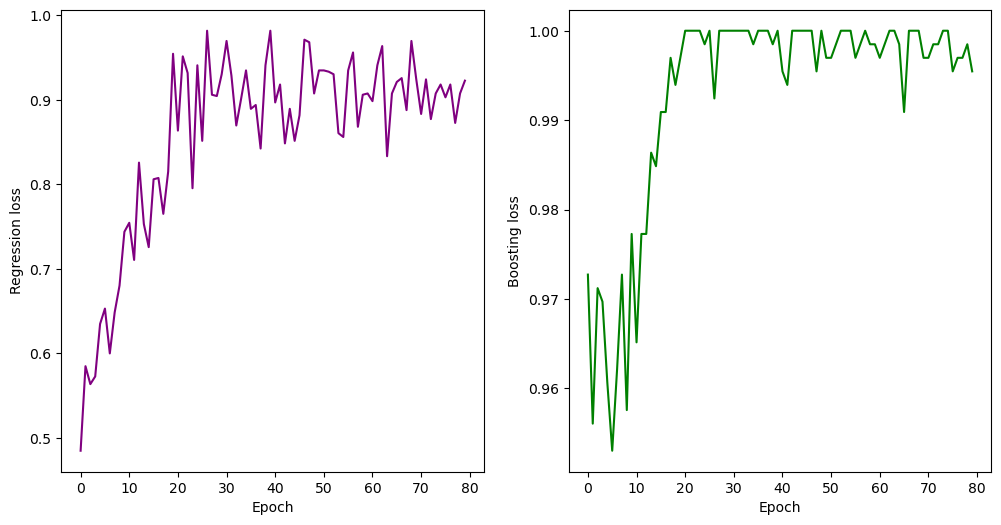

Wall time: 29min 23s


In [117]:
%%time
latent_dim = 10
model = DiffusionGenerator(
    n_inputs=latent_dim + 2*y.shape[1], n_outputs=X_train.shape[1]
)

diffusionFitter = DiffusionFitter(
    model,
    noise_scheduler,
    batch_size=64,
    n_epochs=80,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

C:\Users\vbagrova\AppData\Local\Temp\ipykernel_17920\3189636498.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


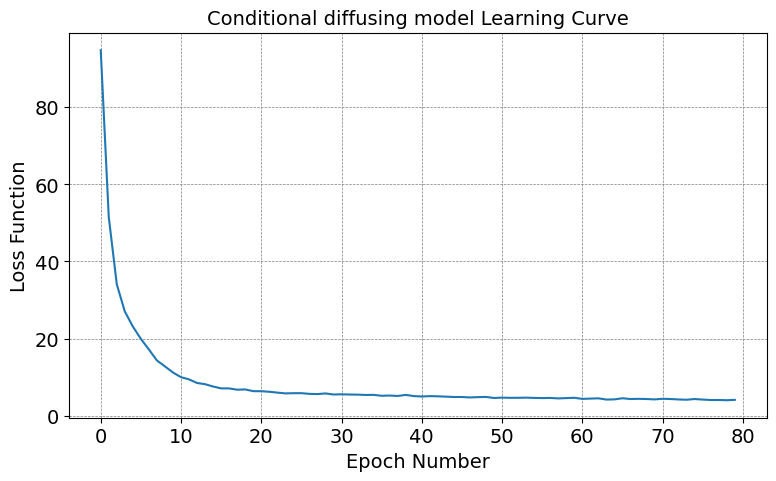

In [118]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

Сначала посмотрим на распределение, оценим, насколько все плохо

In [119]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [120]:
X_fake_train = generate_with_diffusion(model, y_train, latent_dim, noise_scheduler)
X_fake_train = qt.inverse_transform(X_fake_train)

1000it [00:19, 51.77it/s]


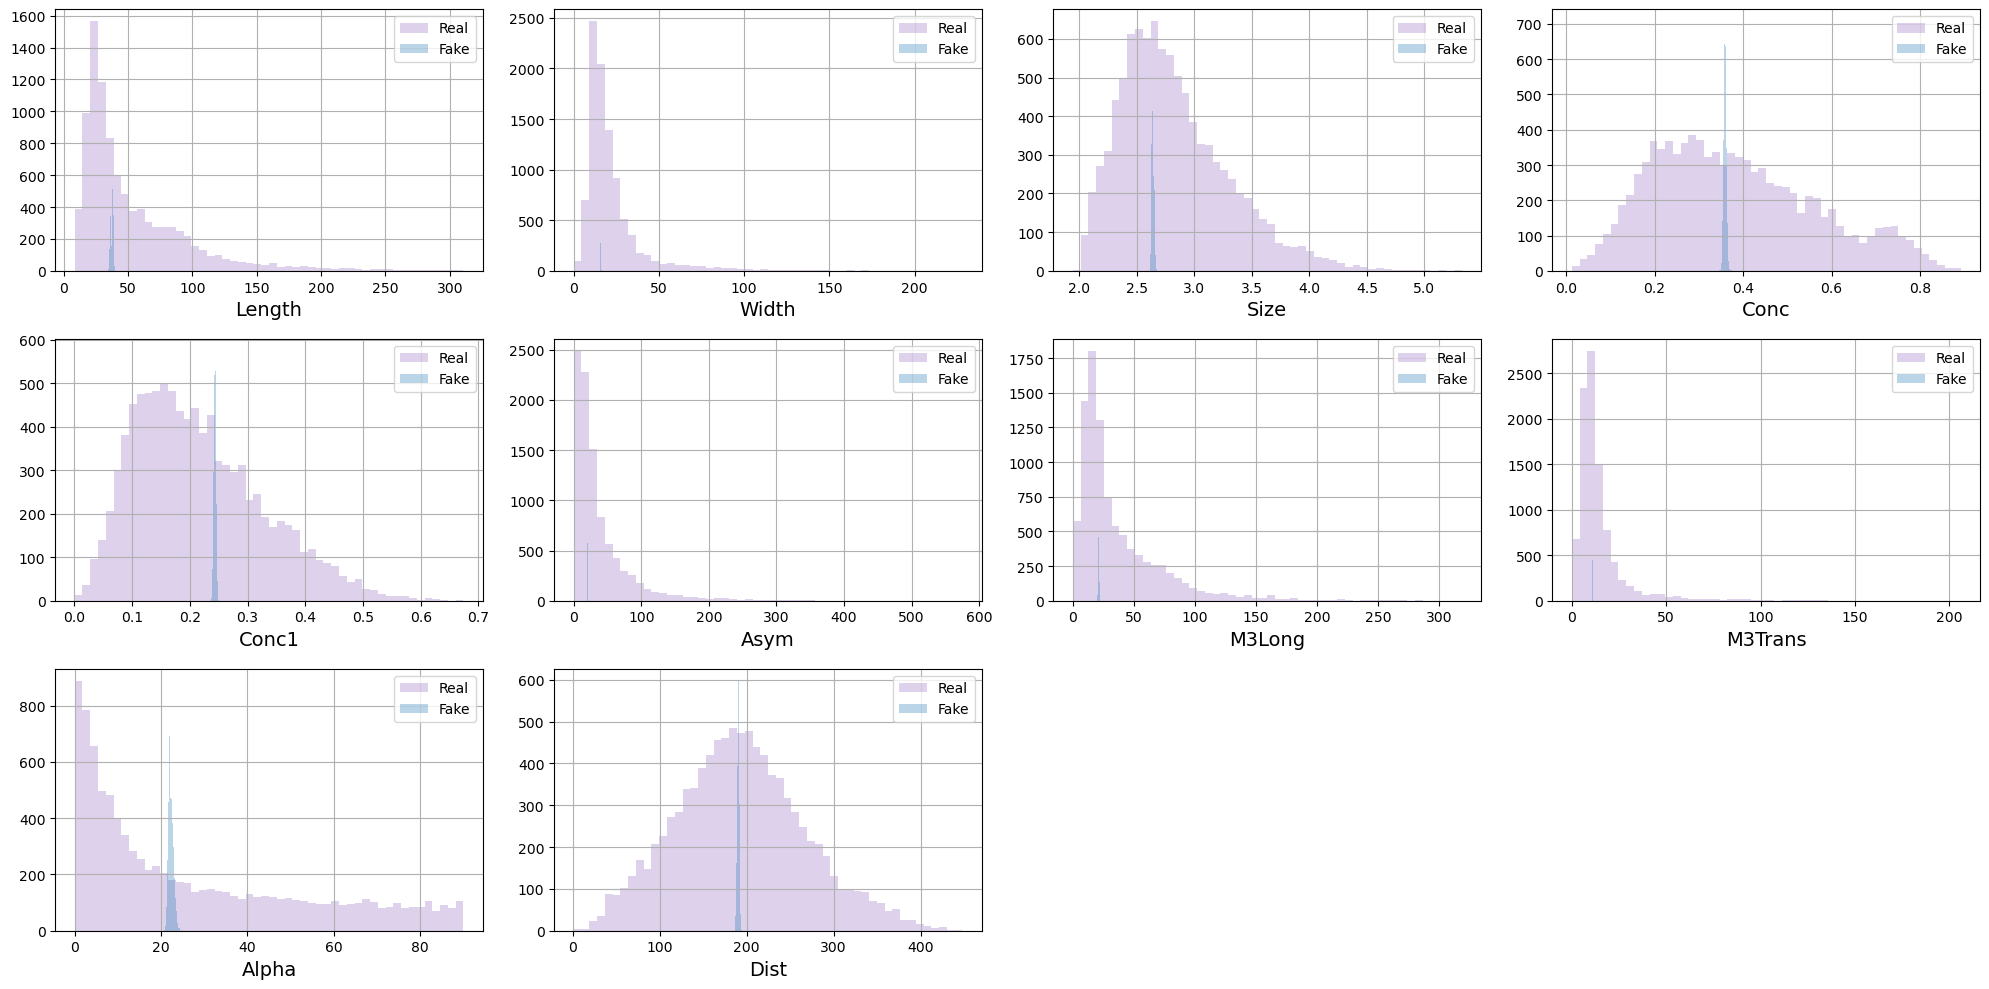

In [121]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [122]:
X_fake_test = generate_with_diffusion(model, y_test, latent_dim, noise_scheduler)
X_fake_test = qt.inverse_transform(X_fake_test)

1000it [00:19, 52.12it/s]


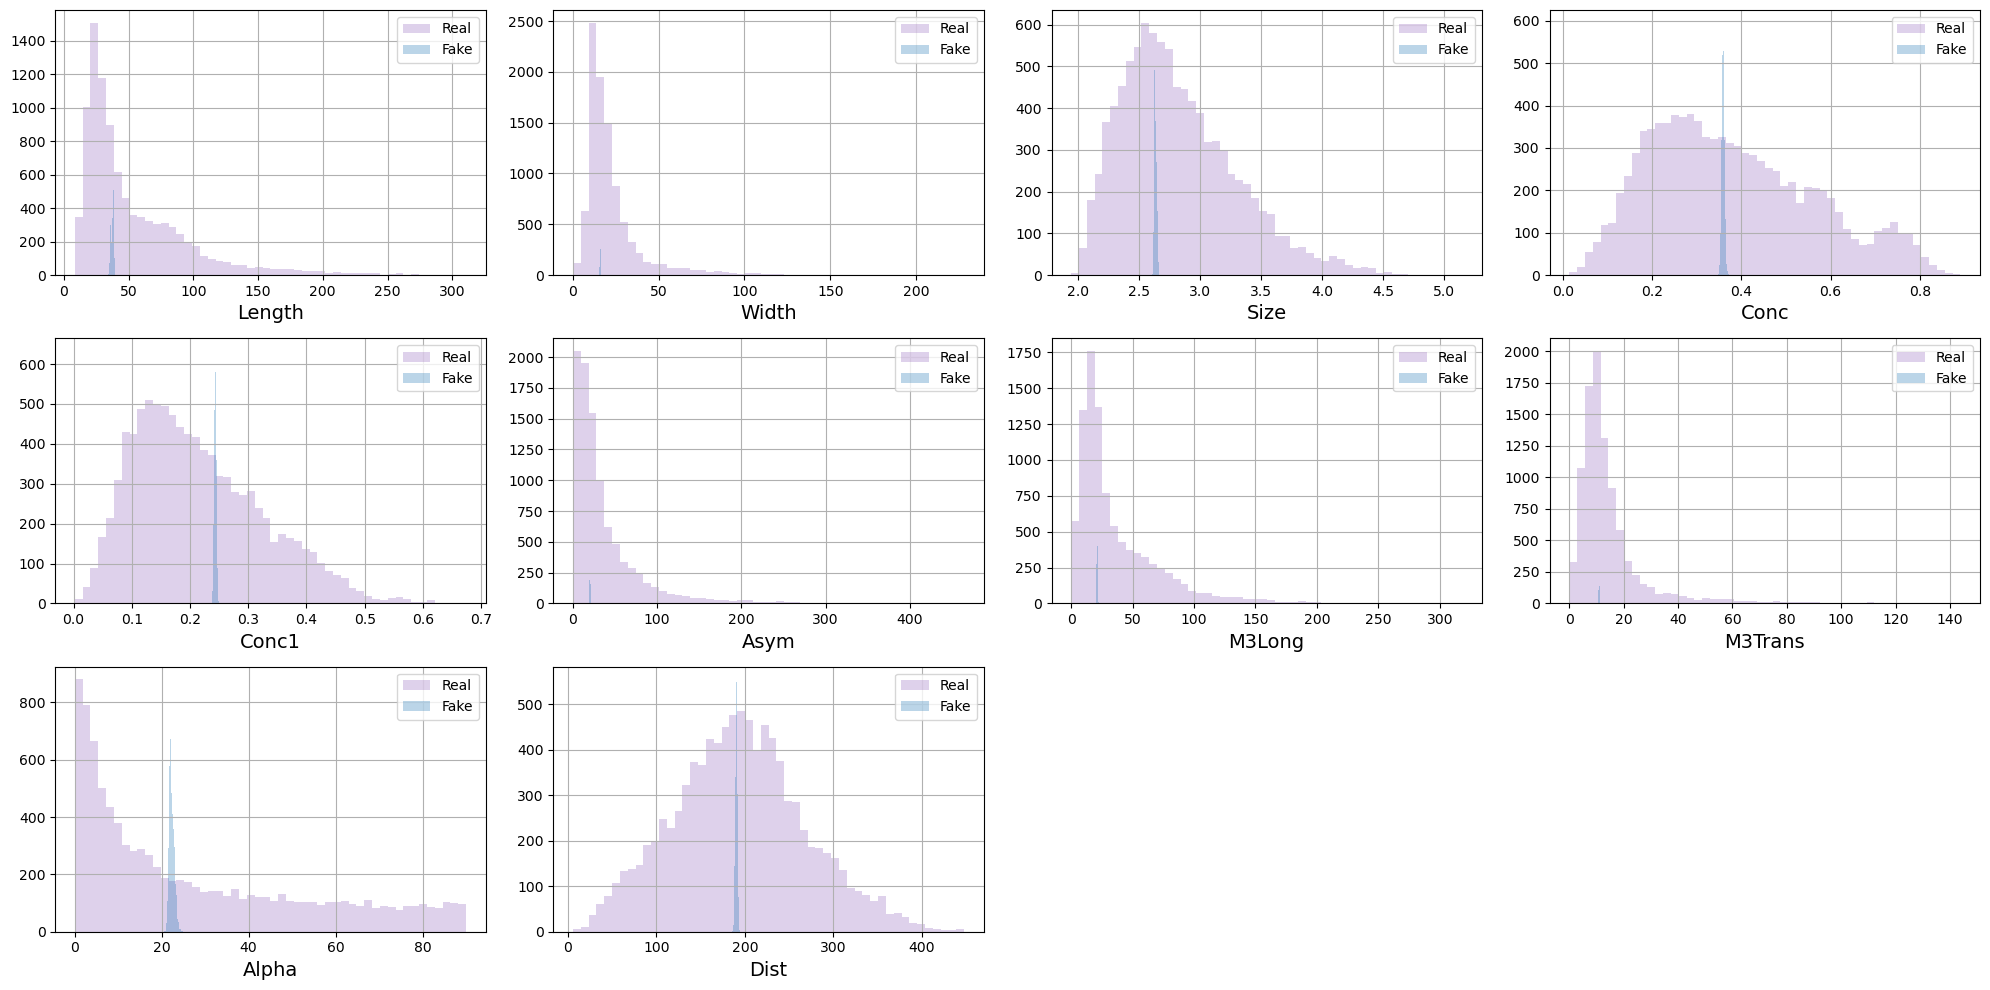

In [123]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [124]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [125]:
# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [126]:
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  1.0


Да, accuracy ужасный. На самом деле странный кейс, общий лосс падает, но при этом accuracy на классификаторе очень большое. Очень долго думала, но не понимаю, с чем это может быть связано. Как будто подбирать шум мы научились хорошо, но при этом общий процесс расшумления работает плохо.

В общем в данной ситуации, эта вершина инженерной мысли не оправдала ожиданий и ган отработал лучше. Если там еще параметры подольше поперебирать, то думаю можно и в roc auc 0,6 выйти.

Но глобально же моделька написана, я так долго пыталась понять, как она работает, не зануляйте пожалуйста :(

И вот прикрепляю красивую картиночку того как я делала домашку)
<center><img src="img/wewilldie.jpg" width="1000"></center>

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

Диффузионку надо разбирать подробнее, ибо очень тяжело